# Data preparation

In [5]:
import os
import pandas as pd
import torch
import numpy as np
import mlflow
from torch import nn, Tensor
import math
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from mlflow.models.signature import infer_signature
import os

In [12]:
MLFLOW_IP = os.environ['MLFLOW_IP']
MLFLOW_PASSWORD = os.environ['MLFLOW_PASSWORD']
MLFLOW_USER = os.environ['MLFLOW_USER']
MLFLOW_PORT = os.environ['MLFLOW_PORT']

In [13]:
if torch.cuda.is_available():
    DEVICE='cuda:0'
else:
    DEVICE='cpu'

In [14]:
curr_time = datetime.now()
start_time = datetime(curr_time.year - 5, curr_time.month , curr_time.day)

data = pdr.get_data_yahoo('AAPL', start_time, curr_time)

data.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-18 00:00:00-05:00,44.842499,45.025002,44.562500,44.814999,42.614574,124773600
2018-01-19 00:00:00-05:00,44.652500,44.895000,44.352501,44.615002,42.424389,129700400
2018-01-22 00:00:00-05:00,44.325001,44.445000,44.150002,44.250000,42.077324,108434400
2018-01-23 00:00:00-05:00,44.325001,44.860001,44.205002,44.259998,42.086815,130756400
2018-01-24 00:00:00-05:00,44.312500,44.325001,43.299999,43.555000,41.416439,204420400


In [15]:
data.isnull().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

# Dataset definition

In [16]:
class TransformerDataset(torch.utils.data.Dataset):
    """
    Special dataset class for training transformer neural network on stock prices data.
    """
    def __init__(self, data, indices, enc_seq_len,
                 dec_seq_len, target_seq_len, normalize=False):
        """
        Constructor for dataset class
        Args:
            data: pd.DataFrame. Data to work with
            indices: list of tuples of indices, marking starting and ending of subsequences
            enc_seq_len: sequence length for encoder
            dec_seq_len: sequence length for decode
            target_seq_len: sequence length of target
            normalize: whether to normalize data by columns or not
        """
        self.data = data
        self.indices = indices
        self.enc_seq_len = enc_seq_len
        self.dec_seq_len = dec_seq_len
        self.target_seq_len = target_seq_len
        if normalize:
            self.data = (self.data-self.data.mean())/self.data.std()
        
    def __len__(self):
        """
        Get length of dataset class
        Returns: length of dataset

        """
        return len(self.indices)
    
    def __getitem__(self, index):
        """
        Get tuple: [src, trg, trg_y]

        Args:
            index: int, index to get item
        """
        starting_index = self.indices[index][0]
        ending_index = self.indices[index][1]
        
        sequence = self.data[starting_index:ending_index]
        
        return self.get_src_trg(sequence)
        
    def get_src_trg(self, sequence):
        """
        Get source, target, and ground truth from sequence, that's input of Transformer class.
        Args:
            sequence: sequence to divide

        Returns:

        """
        assert(len(sequence)==self.dec_seq_len+self.target_seq_len)
        
        src = sequence[:self.enc_seq_len]
        trg = sequence[self.enc_seq_len-1:len(sequence)-1]
        
        assert(len(trg) == self.target_seq_len)
        trg_y = sequence[-self.target_seq_len:]
        
        assert(len(trg_y) == self.target_seq_len)
        src = torch.tensor(src.values.astype(np.float32))
        trg = torch.tensor(trg.values.astype(np.float32))
        trg_y = torch.tensor(trg_y.values.astype(np.float32))
        return src, trg, trg_y

# Model definition

In [17]:
class CompatiableTransformer(nn.Module):
    """
    Special transformer class to be compatible with mlflow interface of predict.
    """
    # Constructor
    def __init__(
        self,
        dim_model,
        out_dim,
        num_heads,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dropout_p=.2,
    ):
        """
        Constructor of Transformer class.
        Args:
            dim_model: a.k.a. dimensionality of input
            out_dim: dimensionality of output
            num_heads: amount of heads in Transformer layer
            num_encoder_layers: amount of encoder layers of Transformer
            num_decoder_layers: amount of decoder layers of Transformer
            dropout_p: probability of dropout, apllies to neurons.
        """
        super().__init__()

        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoder(
            d_model=dim_model, dropout=dropout_p, max_seq_len=150
        )
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, out_dim)

    def forward(
        self,
        model_input
    ):
        """
        Predict, compatible with mlflow interface
        Args:
            model_input: numpy.array. Input to model.

        Returns: Model prediction for given input
        """
        import pandas as pd
        df = pd.DataFrame(model_input)
        src = torch.tensor(df.iloc[-150:].values.astype(np.float32)).unsqueeze(0)
        trg = src[:, -1, 3].unsqueeze(-1).unsqueeze(-1)
        for _ in range(10):
            pred = self.inner_forward(src, trg)[-1, 0, 0]
            next_item = torch.tensor([[pred]], device=self.device).unsqueeze(0)
            trg = torch.cat((trg, next_item), dim=1)
        # return (trg[0, 1:, 0].cpu()*stds[3]+means[3])
        return trg[0, 1:, 0].cpu()
    
    def inner_forward(self, src, tgt):
        """
        Usual forward of base neural network model
        Args:
            src: source sequence
            tgt: target sequence

        Returns: predictions of model

        """
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        # we permute to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        
        self.device = src.device
        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=self.get_tgt_mask(tgt.shape[0]))
        out = self.out(transformer_out)
        return out
    
    def get_tgt_mask(self, size) -> torch.tensor:
        """
        Get target mask, for masked input, to make neural network actually learn. It hides last n-i tokens.
        Args:
            size: size of matrix

        Returns: squared matrix, filled with 0-inf

        """
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask.to(device=self.device)

In [18]:
class PositionalEncoder(nn.Module):
    """
    Positional encoder. Encodes position of element in sequence with usage of two periodic functions.
    """
    def __init__(self, dropout=0.1, max_seq_len=5000, d_model=512, batch_first=False):
        """
        Constructor class for PositionalEncoder
        Args:
            dropout: PositionalEncoder dropout probability
            max_seq_len: max length of sequence
            d_model: d_model parameter
            batch_first: Bool, whether batch dim goes first
        """
        super().__init__()
        
        self.d_model = d_model    
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        
        self.x_dim = 1 if batch_first else 0
        
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(max_seq_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Apply positional encoder for given input x
        Args:
            x: given input

        Returns: positional encoded input

        """
        x = x + self.pe[:x.size(self.x_dim)]
        
        return self.dropout(x)

In [19]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-18 00:00:00-05:00,44.842499,45.025002,44.562500,44.814999,42.614574,124773600
2018-01-19 00:00:00-05:00,44.652500,44.895000,44.352501,44.615002,42.424389,129700400
2018-01-22 00:00:00-05:00,44.325001,44.445000,44.150002,44.250000,42.077324,108434400
2018-01-23 00:00:00-05:00,44.325001,44.860001,44.205002,44.259998,42.086815,130756400
2018-01-24 00:00:00-05:00,44.312500,44.325001,43.299999,43.555000,41.416439,204420400


# Utility functions

In [20]:
def get_src_trg(self, sequence, enc_seq_len, target_seq_len):
        """
        Get tuples of source, target and ground truth for Transformer neural network
        Args:
            sequence: sequence to split
            enc_seq_len: length of encoder sequence
            target_seq_len: length of decoder sequence

        Returns: tuple, containing source, target and ground truth
        """
        assert (len(sequence) == enc_seq_len + target_seq_len)
        
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]

        trg = trg[:, 0]

        if len(trg.shape) == 1:
            trg = trg.unsqueeze(-1)
        
        assert (len(trg) == target_seq_len)

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        trg_y = trg_y[:, 0]
        
        assert (len(trg_y) == target_seq_len)

        return src, trg, trg_y.squeeze(-1)

In [21]:
def generate_square_subsequent_mask(target_sequence_length, encoder_sequence_length):
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Args:
        target_sequence_length: length of target sequence
        encoder_sequence_length: length of encoder sequence
    """
    return torch.triu(torch.ones(target_sequence_length, encoder_sequence_length) * float('-inf'), diagonal=1)

In [22]:
def get_indices_entire_sequence(data: pd.DataFrame, window_size, step_size):
        """
        Split data to indices for Transformer neural network learning
        Args:
            data: data to split
            window_size: size of sliding window (aka seq length)
            step_size: how many values to skip in each iteration

        Returns:
            list of indices
        """
        stop_position = len(data)-1 # 1- because of 0 indexing        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

In [23]:
def reset_weights(m):
    """
    Reset all weights of neural network model
    Args:
        m: model
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

### train/test split

In [24]:
train_size=0.85
train_size_abs = int(len(data)*train_size)

train_data = data[0:train_size_abs]
test_data = data[train_size_abs:]

In [25]:
#Model parameters
n_epochs = 100
lr = 1e-3
dim_val = 512 
n_heads = 8 
n_decoder_layers = 4
n_encoder_layers = 4
input_size = 6
dec_seq_len = 50
enc_seq_len = 50
output_sequence_length = 10
window_size = enc_seq_len+output_sequence_length
max_seq_len = enc_seq_len 
batch_first = False
normalize = True
batch_size=100
dropout_dec = .2
dropout_enc = .2
dropout_pos_enc = .1

In [26]:
training_indices = get_indices_entire_sequence(train_data, window_size, 1)
training_dataset = TransformerDataset(train_data,
                                      training_indices,
                                      enc_seq_len,
                                      dec_seq_len,
                                      output_sequence_length,
                                      normalize=normalize)

training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size)

test_indices = get_indices_entire_sequence(test_data, window_size, 1)
test_dataset = TransformerDataset(test_data,
                                      test_indices,
                                      enc_seq_len,
                                      dec_seq_len,
                                      output_sequence_length,
                                      normalize=normalize)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size)

trg_mask = generate_square_subsequent_mask(
    output_sequence_length,
    output_sequence_length
   )

src_mask = generate_square_subsequent_mask(
    output_sequence_length,
    enc_seq_len
    )

# Train

We will use MSE loss because we want to penalty our model for big mistakes stronger, because It would lead us to lose money

In [27]:
from tqdm.autonotebook import tqdm

In [28]:
mlflow.set_tracking_uri("http://{}:{}".format(MLFLOW_IP, MLFLOW_PORT))

In [ ]:
experiment_id = mlflow.create_experiment(
    "CompatibleTransformer",
    artifact_location="sftp://{}:{}@{}:/home/godder/mlflow_storage/artifacts".format(MLFLOW_USER, MLFLOW_PASSWORD, MLFLOW_IP),
    tags={"version": ".3"},
)

In [29]:
exp_id = dict(mlflow.get_experiment_by_name("CompatibleTransformer"))['experiment_id']

In [30]:
mlflow.set_experiment(experiment_id=exp_id)
print("Set experiment")

Set experiment


In [31]:
dim_model = 6
num_heads = 6
out_dim = 1
num_encoder_layers = 6
num_decoder_layers = 6
dropout_probability = .2
lr = 2e-5
n_epochs = 150
batch_size = 100
normalize = True

Reset trainable parameters of layer = Linear(in_features=6, out_features=1, bias=True)


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10/150, Training Loss: 1.2007
Epoch 10/150, Validation Loss: 1.4835
Epoch 20/150, Training Loss: 1.0522
Epoch 20/150, Validation Loss: 1.3420
Epoch 30/150, Training Loss: 0.6204
Epoch 30/150, Validation Loss: 1.1699
Epoch 40/150, Training Loss: 0.3515
Epoch 40/150, Validation Loss: 0.9454
Epoch 50/150, Training Loss: 0.2685
Epoch 50/150, Validation Loss: 0.9113
Epoch 60/150, Training Loss: 0.2305
Epoch 60/150, Validation Loss: 0.8844
Epoch 70/150, Training Loss: 0.2146
Epoch 70/150, Validation Loss: 0.8298
Epoch 80/150, Training Loss: 0.1953
Epoch 80/150, Validation Loss: 0.9060
Epoch 90/150, Training Loss: 0.1818
Epoch 90/150, Validation Loss: 0.8267
Epoch 100/150, Training Loss: 0.1778
Epoch 100/150, Validation Loss: 0.8447
Epoch 110/150, Training Loss: 0.1705
Epoch 110/150, Validation Loss: 0.8172
Epoch 120/150, Training Loss: 0.1728
Epoch 120/150, Validation Loss: 0.8519
Epoch 130/150, Training Loss: 0.1602
Epoch 130/150, Validation Loss: 0.8521
Epoch 140/150, Training Loss: 

/home/godder/.local/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type CompatiableTransformer. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/godder/.local/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type PositionalEncoder. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
Registered model 'CompatibleTransformer' already exists. Creating a new version of this model...
2023/01/18 08:32:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CompatibleTransformer, version 29


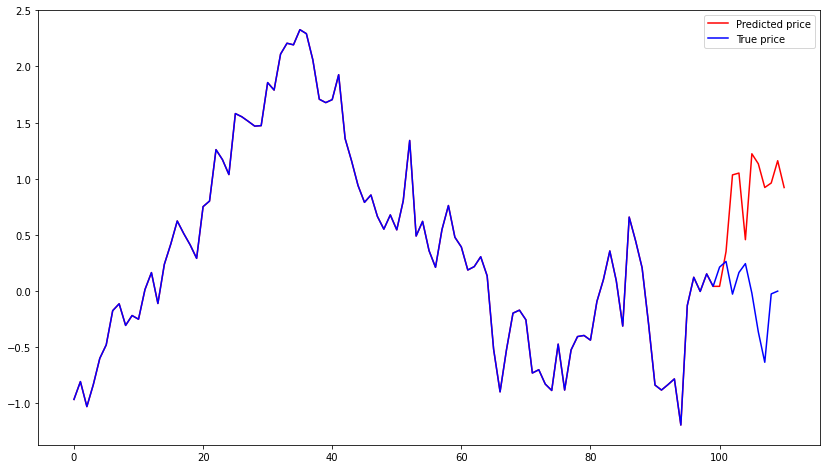

In [44]:
model = CompatiableTransformer(dim_model=6, num_heads=6, out_dim=1,
                               num_encoder_layers=6, num_decoder_layers=6, dropout_p=dropout_probability).to(device=DEVICE)
reset_weights(model)
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
with mlflow.start_run(experiment_id=exp_id,
                      run_name="Transformer training and evaluation"):
    mlflow.set_tag('ticker', 'AAPL')
    mlflow.log_param("dim_model", dim_model)
    mlflow.log_param("num_heads", num_heads)
    mlflow.log_param("n_epochs", n_epochs)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("num_enc_layers", num_encoder_layers)
    mlflow.log_param("num_dec_layers", num_decoder_layers)
    mlflow.log_param("dropout_probability", dropout_probability)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("normalize", normalize)
    
    for epoch in tqdm(range(n_epochs)):    
        train_epoch_losses = []
        val_epoch_losses = []

        for src, trg, trg_y in training_dataloader:
            src = src.to(device=DEVICE)
            trg = trg.to(device=DEVICE)
            trg_y = trg_y.to(device=DEVICE)[:, :, 3].unsqueeze(-1)
            optimizer.zero_grad()
            trg_y = trg_y.permute(1, 0, 2)
            output = model.inner_forward(src, trg)
            loss = criterion(output, trg_y)
        
            train_epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        
        mlflow.log_metric("train_loss", np.mean(train_epoch_losses), step=epoch)
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {np.mean(train_epoch_losses):.4f}')


        for src, trg, trg_y in test_dataloader:
            src = src.to(device=DEVICE)
            trg = trg.to(device=DEVICE)
            trg_y = trg_y.to(device=DEVICE)[:, :, 3].unsqueeze(-1)
            trg_y = trg_y.permute(1, 0, 2)
            output = model.inner_forward(src, trg)
            loss = criterion(output, trg_y)
            val_epoch_losses.append(loss.item())    
            
        mlflow.log_metric("val_loss", np.mean(val_epoch_losses), step=epoch)
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Validation Loss: {np.mean(val_epoch_losses):.4f}')

    torch.save({'state_dict': model.state_dict()},
           'models/transformer.pth')

    signature = mlflow.models.signature.infer_signature(np.array(torch.tensor(data.values).numpy()).astype(np.float64))
    
    mlflow.pytorch.log_model(model,
             'transformer.pth',
             registered_model_name='CompatibleTransformer',
             signature = signature,
             input_example = np.array(torch.tensor(data.values).numpy())
             )
    
    
    #save plot to mlflow
    src, trg, trg_y = next(iter(test_dataloader))
    src = src[:, -1, :]
    true_y = trg_y[-10:, -1, 3]
    rolling_row_target = trg_y[-10:, -1, 3].to(device=DEVICE).unsqueeze(-1).unsqueeze(0)
    trg = src[-1, 3]
    src = src.unsqueeze(0).to(device=DEVICE)
    trg = trg.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device=DEVICE)
    for _ in range(1, 11):
        pred = model.inner_forward(src, rolling_row_target[:, :_, :])[-1, 0, 0]
        next_item = torch.tensor([[pred]], device=DEVICE).unsqueeze(0)
        trg = torch.cat((trg, next_item), dim=1)

    true_y = true_y.unsqueeze(0)
    src = src.cpu()
    true_plot_arr = torch.cat((src[:, :, 3], true_y), dim=1)
    true_plot_arr = true_plot_arr[0, :]
    trg = trg[:, :, 0]
    pred_plot_arr = torch.cat((src[:, :, 3], trg.cpu()), dim=1)
    pred_plot_arr = pred_plot_arr[0, :]

    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    ax.plot(pred_plot_arr, color='red', label='Predicted price')
    ax.plot(true_plot_arr, color='blue', label='True price')
    ax.legend()

    mlflow.log_figure(fig, 'test_plot.png')

# Visualize results

We want to predict and visualise 10 bars (frames), and compare it with genuine values.

In [45]:
model = model.eval()

This prediction is such, that at each given step, model uses true data trg (second argument) instead of each predictions. That's more realistic way to use stocks data market prediction

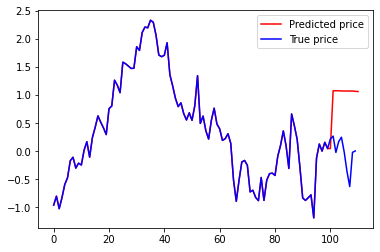

In [46]:
src, trg, trg_y = next(iter(test_dataloader))
src = src[:, -1, :]
true_y = trg_y[-10:, -1, 3]
rolling_row_target = trg_y[-10:, -1, 3].to(device=DEVICE).unsqueeze(-1).unsqueeze(0)
trg = src[-1, 3]
src = src.unsqueeze(0).to(device=DEVICE)
trg = trg.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device=DEVICE)
for _ in range(1, 11):
    pred = model.inner_forward(src, rolling_row_target[:, :_, :])[-1, 0, 0]
    next_item = torch.tensor([[pred]], device=DEVICE).unsqueeze(0)
    trg = torch.cat((trg, next_item), dim=1)
    
true_y = true_y.unsqueeze(0)
src = src.cpu()
true_plot_arr = torch.cat((src[:, :, 3], true_y), dim=1)
true_plot_arr = true_plot_arr[0, :]
trg = trg[:, :, 0]
pred_plot_arr = torch.cat((src[:, :, 3], trg.cpu()), dim=1)
pred_plot_arr = pred_plot_arr[0, :]

plt.plot(pred_plot_arr, color='red', label='Predicted price')
plt.plot(true_plot_arr, color='blue', label='True price')
plt.legend()
plt.show()

This prediction is such, that model uses it's own prediction to predict next value. That's usual time-series forecasting situation but in stocks price prediction, we gets new data each hour and usually makes trade by prediction of next frame. 

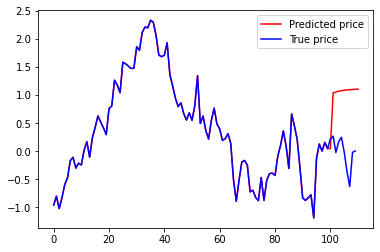

In [47]:
src, trg, trg_y = next(iter(test_dataloader))
src = src[:, -1, :]
true_y = trg_y[-10:, -1, 3]
trg = src[-1, 3]
src = src.unsqueeze(0).to(device=DEVICE)
trg = trg.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device=DEVICE)
for _ in range(10):
    pred = model.inner_forward(src, trg)[-1, 0, 0]
    next_item = torch.tensor([[pred]], device=DEVICE).unsqueeze(0)
    trg = torch.cat((trg, next_item), dim=1)
    
true_y = true_y.unsqueeze(0)
src = src.cpu()
true_plot_arr = torch.cat((src[:, :, 3], true_y), dim=1)
true_plot_arr = true_plot_arr[0, :]

trg = trg[:, :, 0]
pred_plot_arr = torch.cat((src[:, :, 3], trg.cpu()), dim=1)
pred_plot_arr = pred_plot_arr[0, :]

plt.plot(pred_plot_arr, color='red', label='Predicted price')
plt.plot(true_plot_arr, color='blue', label='True price')
plt.legend()
plt.show()

# Wrapper

In [ ]:
# class CustomTransformer(mlflow.pyfunc.PythonModel):
#     def __init__(self, params=None, **kwargs):
#         super().__init__()
#         if torch.cuda.is_available():
#             self.device = 'cuda:0'
#         else:
#             self.device = 'cpu'
        
#     def load_context(self, context):
#         import torch
#         import mlflow.pytorch
        
#         if torch.cuda.is_available():
#             self.torch_model = mlflow.pytorch._load_pyfunc(context.artifacts["torch_model"])
#             self.device = 'cuda:0'
#         else:
#             self.torch_model = mlflow.pytorch._load_pyfunc(
#                 context.artifacts["torch_model"],
#                 map_location=torch.device('cpu')
#             )
#             self.device = 'cpu'
            
#     def predict(self, context, model_input: pd.DataFrame):
#         import torch
#         df = model_input
#         means = df.mean()
#         stds = df.std()
        
#         df_normed = (df-means)/stds
#         src = torch.tensor(df_normed.iloc[-150:].values.astype(np.float32)).unsqueeze(0).to(device=self.device)
#         trg = src[:, -1, 3].unsqueeze(-1).unsqueeze(-1)
        
#         for _ in range(10):
#             pred = self.torch_model.predict(src, trg)[-1, 0, 0]
#             next_item = torch.tensor([[pred]], device=self.device).unsqueeze(0)
#             trg = torch.cat((trg, next_item), dim=1)
#         return trg[0, 1:, 0].cpu().numpy()*stds[3]+means[3]

In [ ]:
# mlflow.search_experiments()

In [ ]:
# runs = mlflow.search_runs(experiment_names=['Transformer'])
# last_run_id = runs.where(runs['status']=='FINISHED').sort_values(by='end_time', ascending=False).iloc[0]['run_id']

In [ ]:
# with mlflow.start_run(experiment_id=experiment_id,
#                       run_name="Working Custom Transformer wrapper"):
#     model = mlflow.pyfunc.log_model(
#         artifact_path='CustomTransformer/1',
#         python_model=CustomTransformer(),
#         conda_env=mlflow.pyfunc.get_default_conda_env(),
#         artifacts = {
#               "torch_model": "models:/Transformer/1",
#               "pickle_info": "runs:/{}/transformer.pth/data/pickle_module_info.txt".format(last_run_id)
#         },
#     )

# Fetching and checking model

In [47]:
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/CompatibleTransformer/28"
)

In [48]:
model.predict(torch.tensor(data.values).numpy())

array([-0.46924025, -0.79872596, -0.6352958 , -0.6824335 , -0.5875571 ,
       -0.6474445 , -0.6436279 , -0.6438367 , -0.6425495 , -0.64182544],
      dtype=float32)

# Dealing with Stages and Tags for registered models

In [48]:
tracking_uri = mlflow.get_tracking_uri()
registry_uri = mlflow.get_registry_uri()

In [49]:
client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)
client.transition_model_version_stage(
    name="CompatibleTransformer",
    version=29,
    stage="Staging"
)
print('done')

done


In [51]:
client.set_model_version_tag(
    name="CompatibleTransformer",
    version="29",
    key="ticker",
    value="AAPL"
)

In [52]:
#Tag non used models as 'Archived'
for i in range(25, 29):
    client.transition_model_version_stage(
    name="CompatibleTransformer",
    version=i,
    stage="Archived"
)